In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import re
import ipywidgets as widgets
from util.util import get_options_from_file, ewma_halflife
modelBase = Path('checkpoints')
val_log_file = 'val_loss_log.csv'
models = list(modelBase.rglob(val_log_file))

In [106]:
# Select model to inspect validation loss
strModels = [str(mdl.parts[-2]) for mdl in models]
selectedModel = widgets.Dropdown(
    options=strModels,
    value=strModels[0],
    description='Model name:',
    disabled=False,
    layout = {'width' : 'initial'}
)
selectedModel

Dropdown(description='Model name:', layout=Layout(width='initial'), options=('npyArray16bitValSetResNetBackend…

In [107]:
optDict = get_options_from_file(modelBase / selectedModel.value / 'train_opt.txt')
trainSize, valSize, testSize = [len(list((path / 'A').glob('*'))) for path in [Path(optDict['dataroot']) / elem for elem in ['train', 'val', 'test']]]

In [108]:
val_log = pd.read_csv(modelBase / selectedModel.value / val_log_file)
val_log.head()
val_log['epochs'] = val_log.iters / trainSize

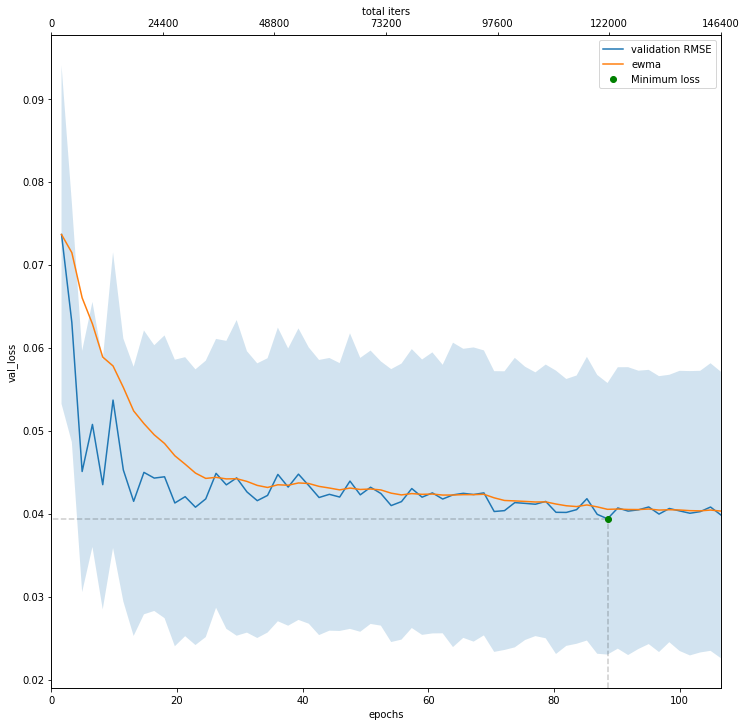

In [109]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)
x1, x2 = 'epochs', 'iters'
sns.lineplot(x=x1, y='val_loss', data=val_log, label='validation RMSE', ax = ax1)
plt.fill_between(val_log[x1], val_log.val_loss - val_log.val_std, val_log.val_loss + val_log.val_std, alpha = .2)
halflife = 3
plt.plot(val_log[x1], ewma_halflife(val_log.val_loss, halflife), label = 'ewma')

min_row = val_log.sort_values('val_loss', ascending=True).iloc[[0], :]
# sns.scatterplot(min_row.epochs, min_row.val_loss, ax=ax1)
plt.plot(min_row.epochs, min_row.val_loss, 'go', label = 'Minimum loss')

plt.legend()
xlim, ylim = ax1.get_xlim(), ax1.get_ylim()
plt.vlines(min_row.epochs.values[0], ylim[0], min_row.val_loss.values[0], linestyles = 'dashed', alpha = .2)
plt.hlines(min_row.val_loss.values[0], xlim[0], min_row.epochs.values[0], linestyles = 'dashed', alpha = .2)
plt.xlim((0, np.max(val_log[x1])))
plt.ylim(ylim)

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(ax1.get_xticks()*trainSize)
ax2.set_xlabel('total iters');

